In [ ]:
import warnings
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [2]:
import itertools
import time
from functools import partial

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.experimental import sparse as jsparse
from jax.lax import scan, dot_general
import jax.nn as jnn

import optax
import numpy as np
import matplotlib.pyplot as plt

from data import dataset_LLT
from conj_grad import ConjGrad, apply_LLT, apply_Jacobi
from loss import LLT_loss
from model import MessagePassing, FullyConnectedNet, PrecNet
from train import train, compute_loss_LLT, compute_loss_mse
from utils import params_count

# Make dataset

In [3]:
grid = 64
N_samples = 32
# h = 1. / grid

In [4]:
A_train, b_train, u_exact_train, bi_edges_train, nodes_train, edges_train, receivers_train, senders_train = dataset_LLT(grid, N_samples, seed=42)
A_test, b_test, u_exact_test, bi_edges_test, nodes_test, edges_test, receivers_test, senders_test = dataset_LLT(grid, N_samples=10, seed=43)

2024-03-15 13:59:24.332038: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
norm_train = jnp.linalg.norm(edges_train, axis=1)
norm_test = jnp.linalg.norm(edges_test, axis=1)

edges_train = jnp.einsum('bi, b -> bi', edges_train, 1./norm_train)
edges_test = jnp.einsum('bi, b -> bi', edges_test, 1./norm_test)
nodes_train = jnp.einsum('bi, b -> bi', nodes_train, 1./norm_train)
nodes_test = jnp.einsum('bi, b -> bi', nodes_test, 1./norm_test)
b_train = jnp.einsum('bi, b -> bi', b_train, 1./norm_train)
b_test = jnp.einsum('bi, b -> bi', b_test, 1./norm_test)
A_train = A_train / norm_train[..., None, None]
A_test = A_test / norm_test[..., None, None]

# u_exact_train = jnp.einsum('bi, b -> bi', u_exact_train, 1./norm_train)
# u_exact_test = jnp.einsum('bi, b -> bi', u_exact_test, 1./norm_test)
# # A_train = jnp.einsum('bij, b -> bij', A_train, 1./norm_train)
# # A_test = jnp.einsum('bij, b -> bij', A_test, 1./norm_test)
# # A_train = jsparse.BCOO.fromdense(jnp.einsum('bij, b -> bij', A_train.todense(), 1./norm_train))
# # A_test = jsparse.BCOO.fromdense(jnp.einsum('bij, b -> bij', A_test.todense(), 1./norm_test))

# Train model

In [6]:
seed = 42
NodeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(features=[1, 16, 16], N_layers=2, key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(features=[16, 16, 1], N_layers=2, key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(features=[48, 16, 16], N_layers=2, key=random.PRNGKey(seed)),
    mp_rounds=mp_rounds
)

model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)
print(f'Parameter number: {params_count(model)}')

Parameter number: 3009


0.0 0.2850396931171417


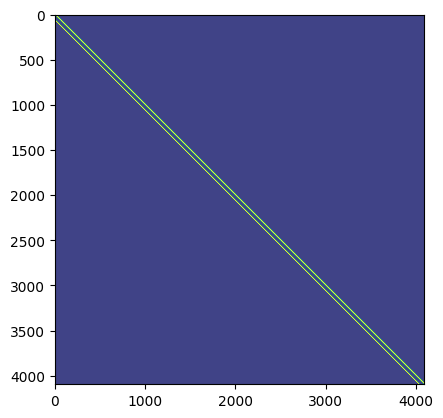

In [7]:
L_before_train = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
print(L_before_train[0, ...].min().item(), L_before_train[0, ...].max().item())
plt.imshow(L_before_train[0, :, :], vmin=A_train.data.min().item(), vmax=A_train.data.max().item());

In [8]:
idx=0
LLT_loss(L_before_train[idx, ...], u_exact_train[idx, ...], b_train[idx, ...])

Array(12444502., dtype=float32)

In [9]:
lr = 1e-3
# start, stop, step = 300, 1001, 300
# decay_size = 1e-1
# lr = optax.piecewise_constant_schedule(
#     lr,
#     {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
# )

In [10]:
X_train = (nodes_train, edges_train, receivers_train, senders_train, bi_edges_train, u_exact_train, b_train, A_train)
X_test = (nodes_test, edges_test, receivers_test, senders_test, bi_edges_test, u_exact_test, b_test, A_test)
data = (X_train, X_test, jnp.array([1]), jnp.array([1]))

train_config = {'optimizer': optax.adam,
                'lr': lr,
                'optim_params': {},#{'weight_decay': 1e-8}, 
                'epoch_num': 500}
model, losses = train(model, data, train_config, compute_loss_LLT)

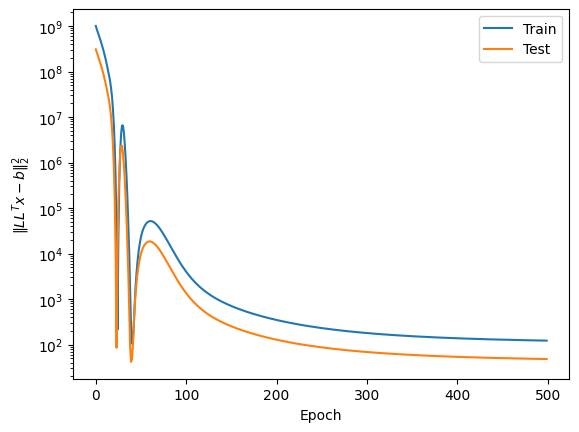

In [11]:
plt.plot(range(len(losses[0])), losses[0], label='Train')
plt.plot(range(len(losses[0])), losses[1], label='Test')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('$\|LL^Tx - b\|_2^2$');

# Check preconditioner

In [12]:
L = vmap(model, in_axes=(0, 0, 0, 0, 0), out_axes=(0))(nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)

In [13]:
A_train.todense()[0, ...].diagonal() - jnp.sqrt(L[0, ...].diagonal())

Array([-0.35875812, -0.35875812, -0.35875812, ..., -0.35875812,
       -0.35875812, -0.35875812], dtype=float32)

In [14]:
# plt.imshow((L[0, ...] @ L[0, ...].T @ u_exact_train[0, ...])[:, None])

In [15]:
a = A_train.todense()[0, ...]
# a = a.at[jnp.nonzero(a)].set(a.max())
display(jnp.linalg.cond(a))
display(jnp.linalg.cond(jnp.tril(a)))
jnp.linalg.cond(jnp.tril(a) @ jnp.tril(a).T)

Array(1711.664, dtype=float32)

Array(2.9939857, dtype=float32)

Array(8.963949, dtype=float32)

In [16]:
print(f'Condition number of A: {jnp.linalg.cond(A_train.todense()[0, ...]):.5f}')
print(f'Condition number of L: {jnp.linalg.cond(L[0, ...]):.5f}')
print(f'Condition number of LLT: {jnp.linalg.cond(L[0, ...] @ L[0, ...].T):.5f}')
print(f'Condition number of Jacobi prec: {jnp.linalg.cond(jnp.diag(jnp.diag(A_train.todense()[0, ...]))):.5f}')

Condition number of A: 1711.66394
Condition number of L: 30.12312
Condition number of LLT: 907.39252
Condition number of Jacobi prec: 1.00000


Array([-0.14609307, -0.14609307, -0.14609307, ..., -0.14609307,
       -0.14609307, -0.14609307], dtype=float32)

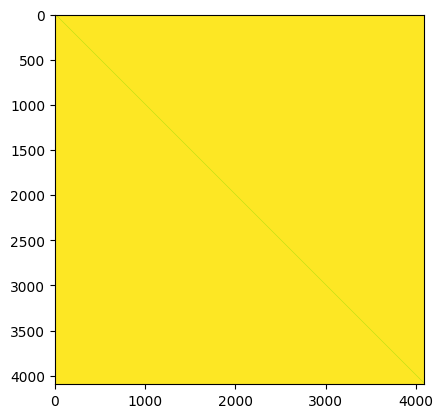

In [17]:
display((L[0, ...] - L_before_train[0, ...]).diagonal())
plt.imshow(jnp.diag((L[0, ...] - L_before_train[0, ...]).diagonal()))

Array([0.13894662, 0.13894662, 0.13894662, ..., 0.13894662, 0.13894662,
       0.13894662], dtype=float32)

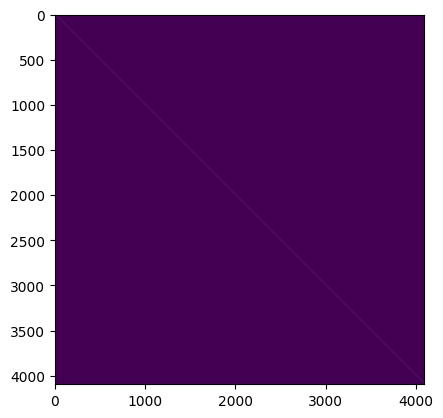

In [18]:
display(L[0, ...].diagonal())
plt.imshow(jnp.diag(L[0, ...].diagonal()))

In [19]:
idx=0
LLT_loss(L[idx, ...], u_exact_train[idx, ...], b_train[idx, ...])

Array(2.1415477, dtype=float32)

In [20]:
idx=0
display(jnp.linalg.norm(A_train.todense()[idx, ...] - L[idx, ...] @ L[idx, ...].T))

Array(1.1616111, dtype=float32)

In [21]:
(A_train.data.min().item(), A_train.data.max().item()), (L[0, receivers_train[0, ...], senders_train[0, ...]].min().item(), L[0, :, :].max().item())

((-0.0034993281587958336, 0.013997312635183334),
 (-0.06543156504631042, 0.13894662261009216))

0.0 0.33327874541282654


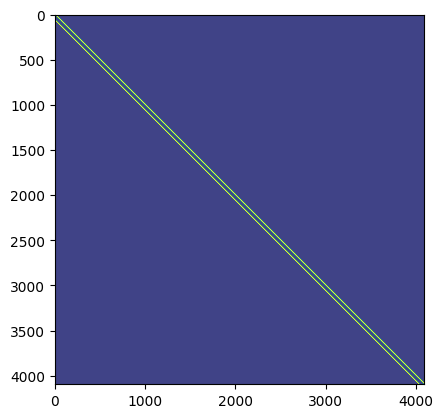

In [22]:
print((L_before_train - L)[0, ...].min().item(), (L_before_train - L)[0, ...].max().item())
plt.imshow((L_before_train - L)[0, ...], vmin=A_train.data.min().item(), vmax=A_train.data.max().item())

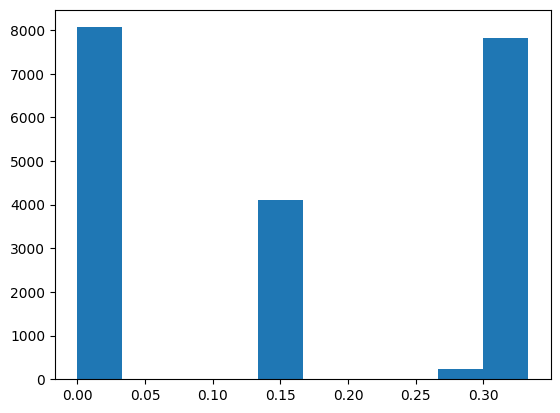

In [23]:
plt.hist((L_before_train - L)[0, receivers_train[0, ...], senders_train[0, ...]]);

Array([0.13894662, 0.00688574, 0.13894662, ..., 0.00688575, 0.00688572,
       0.13894662], dtype=float32)

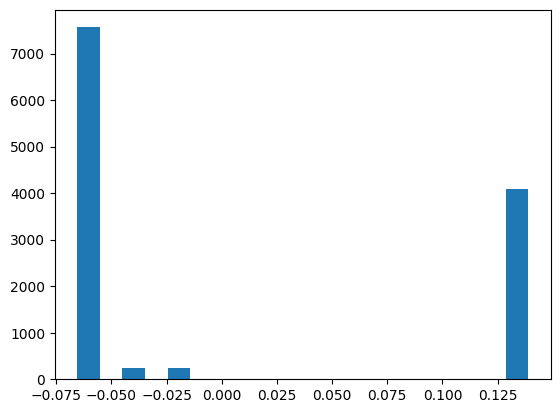

In [24]:
display(L[0, jnp.nonzero(L[0, ...])[0], jnp.nonzero(L[0, ...])[1]])
plt.hist(L[0, jnp.nonzero(L[0, ...])[0], jnp.nonzero(L[0, ...])[1]], bins=20);

A
  min: -0.00350, max:0.01400
L
  min: -0.06543, max:0.13895
LLT
  min: -0.00909, max:0.02787
LLT^(-1)
  min: -3.98274, max:154.10130


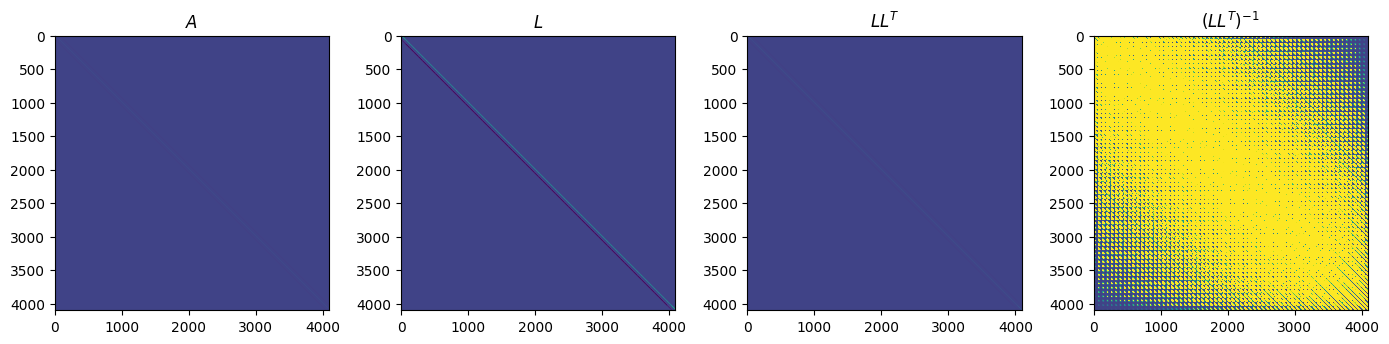

In [25]:
_, axes = plt.subplots(1, 4, figsize=(14, 14))

print(f'A\n  min: {A_train.data.min().item():.5f}, max:{A_train.data.max().item():.5f}')
print(f'L\n  min: {L[0, :, :].min().item():.5f}, max:{L[0, :, :].max().item():.5f}')
print(f'LLT\n  min: {(L[0, :, :] @ L[0, :, :].T).min().item():.5f}, max:{(L[0, :, :] @ L[0, :, :].T).max().item():.5f}')
print(f'LLT^(-1)\n  min: {jnp.linalg.inv(L[0, :, :] @ L[0, :, :].T).min().item():.5f}, max:{jnp.linalg.inv(L[0, :, :] @ L[0, :, :].T).max().item():.5f}')

axes[0].imshow(A_train.todense()[0, :, :], vmin=A_train.data.min().item(), vmax=A_train.data.max().item())
axes[1].imshow(L[0, :, :], vmin=A_train.data.min().item(), vmax=A_train.data.max().item())
axes[2].imshow(L[0, :, :] @ L[0, :, :].T, vmin=A_train.data.min().item(), vmax=A_train.data.max().item())
axes[3].imshow(jnp.linalg.inv(L[0, :, :] @ L[0, :, :].T), vmin=A_train.data.min().item(), vmax=A_train.data.max().item())
# axes[3].imshow(jnp.linalg.inv(L[0, :, :]) @ jnp.linalg.inv(L[0, :, :]).T, vmin=A_train.data.min().item(), vmax=A_train.data.max().item())

# axes[1].imshow(L[0, :, :], vmin=L[0, :, :].min().item(), vmax=L[0, :, :].max().item())
# axes[2].imshow(L[0, :, :] @ L[0, :, :].T, vmin=(L[0, :, :] @ L[0, :, :].T).min().item(), vmax=(L[0, :, :] @ L[0, :, :].T).max().item())

axes[0].set_title('$A$')
axes[1].set_title('$L$')
axes[2].set_title('$LL^T$')
axes[3].set_title('$(LL^T)^{-1}$')

plt.tight_layout()

# Apply model to CG

In [26]:
del A_train, b_train, u_exact_train, bi_edges_train, nodes_train, edges_train, receivers_train, senders_train

In [27]:
# Not preconditioned
# data_cg_train = (A_train, b_train, u_exact_train, nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
data_cg_test = (A_test, b_test, u_exact_test, nodes_test, edges_test, receivers_test, senders_test, bi_edges_test)

X_I, R_I, _ = ConjGrad(data_cg_test, N_iter=300, model=None, prec_func=None, m_max=None, seed=42)

In [28]:
# Apply LLT model
# data_cg_train = (A_train, b_train, u_exact_train, nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)
# X_LLT, R_LLT, _ = ConjGrad(data_cg_train, N_iter=100, model=model, prec_func=apply_LLT, m_max=None, seed=42)

data_cg_test = (A_test, b_test, u_exact_test, nodes_test, edges_test, receivers_test, senders_test, bi_edges_test)
X_LLT, R_LLT, _ = ConjGrad(data_cg_test, N_iter=300, model=model, prec_func=apply_LLT, m_max=None, seed=42)

In [29]:
# Apply Jacobi prec model
# data_cg_train = (A_train, b_train, u_exact_train, nodes_train, edges_train, receivers_train, senders_train, bi_edges_train)

# data_cg_test = (A_test, b_test, u_exact_test, nodes_test, edges_test, receivers_test, senders_test, bi_edges_test)
# X_J, R_J, _ = ConjGrad(data_cg_test, N_iter=300, model=model, prec_func=apply_Jacobi, m_max=None, seed=42)

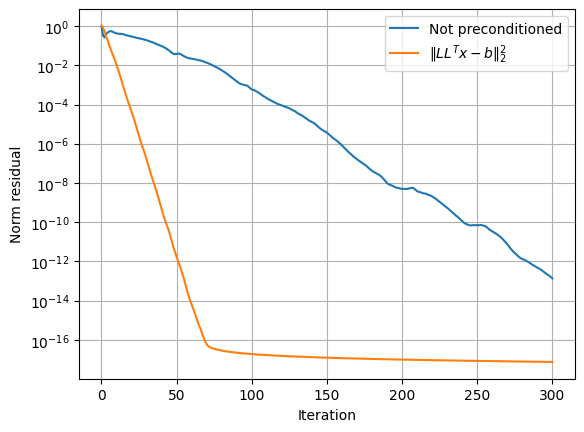

In [30]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="Not preconditioned")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="$\|LL^Tx - b\|_2^2$")
# plt.plot(range(R_J.shape[-1]), jnp.linalg.norm(R_J, axis=1).mean(0), label="Jacobi")

# plt.plot(range(20), jnp.linalg.norm(R_I, axis=1).mean(0)[:20], label="Not preconditioned")
# plt.plot(range(20), jnp.linalg.norm(R_LLT, axis=1).mean(0)[:20], label="$\|LL^Tx - b\|_2^2$")
plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();

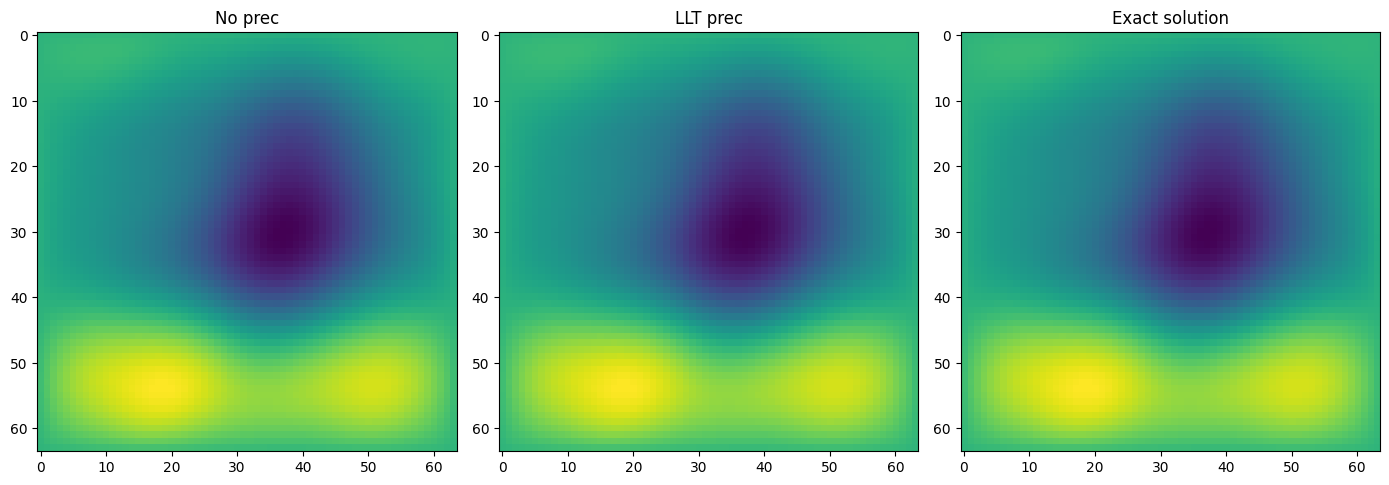

In [31]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('LLT prec')
axes[2].set_title('Exact solution')

plt.tight_layout()

In [32]:
L[0, ...].diagonal()

Array([0.13894662, 0.13894662, 0.13894662, ..., 0.13894662, 0.13894662,
       0.13894662], dtype=float32)

(12160,) 16777216
0.065431565


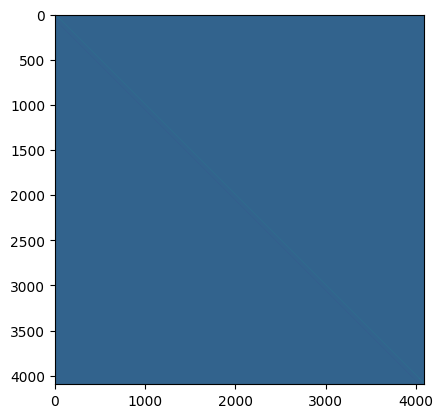

In [33]:
print(jnp.nonzero(L[0, ...])[0].shape, np.prod(L[0, ...].shape))
print(jnp.abs(L[0, ...].min()))
plt.imshow(L[0, ...])

(16777216,) 16777216
3.9827394


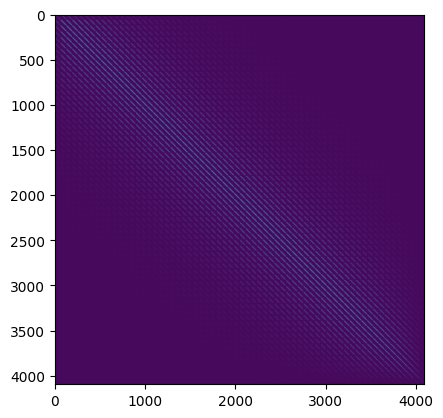

In [34]:
print(jnp.nonzero(jnp.linalg.inv(L[0, ...]@L[0, ...].T))[0].shape, np.prod(L[0, ...].shape))
print(jnp.abs(jnp.linalg.inv(L[0, ...]@L[0, ...].T).min()))
plt.imshow(jnp.linalg.inv(L[0, ...]@L[0, ...].T))

In [35]:
print(jnp.nonzero(A_train.todense()[0, ...])[0].shape, np.prod(A_train[0, ...].shape))
print(jnp.abs(A_train.todense()[0, ...].min()))
plt.imshow(A_train.todense()[0, ...])

NameError: name 'A_train' is not defined

In [ ]:
print(jnp.nonzero(jnp.linalg.inv(A_train.todense()[0, ...]))[0].shape, np.prod(A_train[0, ...].shape))
print(jnp.abs(jnp.linalg.inv(A_train.todense()[0, ...]).min()))
plt.imshow(jnp.linalg.inv(A_train.todense()[0, ...]))

In [ ]:
print(jnp.nonzero(jnp.tril(A_train.todense()[0, ...]) @ jnp.tril(A_train.todense()[0, ...]).T)[0].shape, )
plt.imshow(jnp.tril(A_train.todense()[0, ...]) @ jnp.tril(A_train.todense()[0, ...]).T)